In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import warnings


warnings.filterwarnings("ignore")

/home/dmalberto/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/dmalberto/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
df = pd.read_csv('BTC-USD.csv', parse_dates=['Date'])

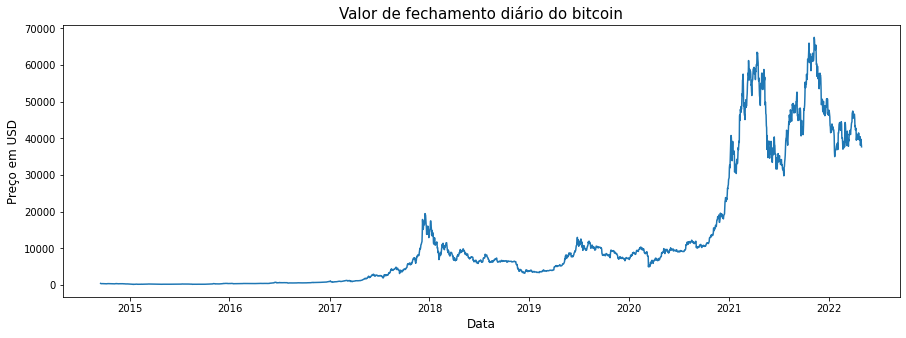

In [22]:
train = df.loc[df['Date'] < '2022-05-01',['Date','Close']].set_index('Date').sort_index()

plt.rcParams["figure.figsize"] = (15,5)
plt.plot(train)

plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço em USD', fontsize=12)
plt.title("Valor de fechamento diário do bitcoin", fontsize=15)


plt.show()

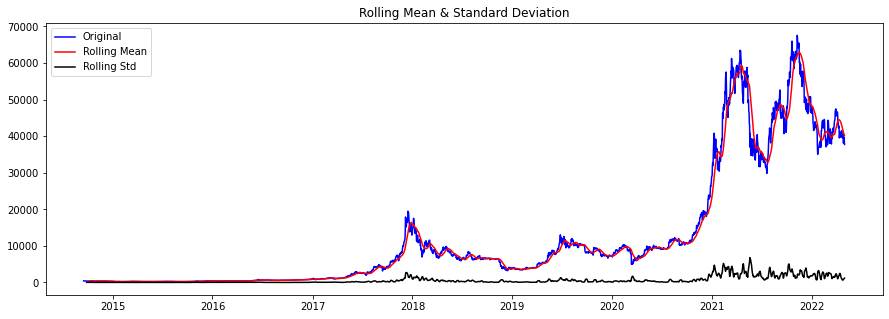

ADF Stastistic: -1.267099
p-value: 0.644087
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [23]:

def test_stationarity(x):
   #Determing rolling statistics
   rolmean = x.rolling(window=22,center=False).mean()
   rolstd = x.rolling(window=12,center=False).std()
   #Plot rolling statistics:
   plt.plot(x, color='blue',label='Original')
   plt.plot(rolmean, color='red', label='Rolling Mean')
   plt.plot(rolstd, color='black', label = 'Rolling Std')
   plt.legend(loc='best')
   plt.title('Rolling Mean & Standard Deviation')
   plt.show(block=False)
   #Perform Dickey Fuller test    
   result=adfuller(x)

   print('ADF Stastistic: %f'%result[0])
   print('p-value: %f'%result[1])
   pvalue=result[1]
   print("The graph is non stationery" if result[0]> result[4]['1%'] else "The graph is stationery")
   print('Critical values:')
   for key,value in result[4].items():
      print('\t%s: %.3f ' % (key, value))
        
ts = train['Close']      
test_stationarity(ts)

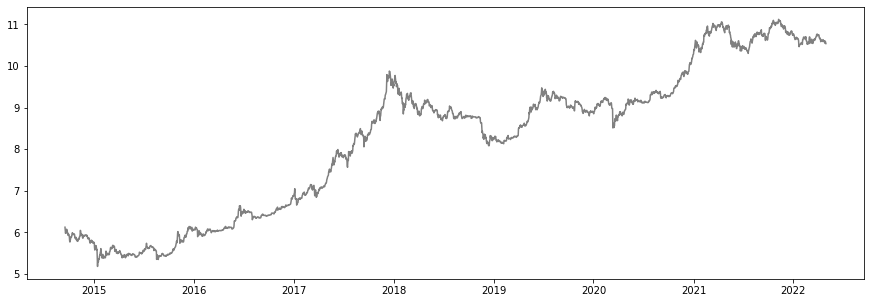

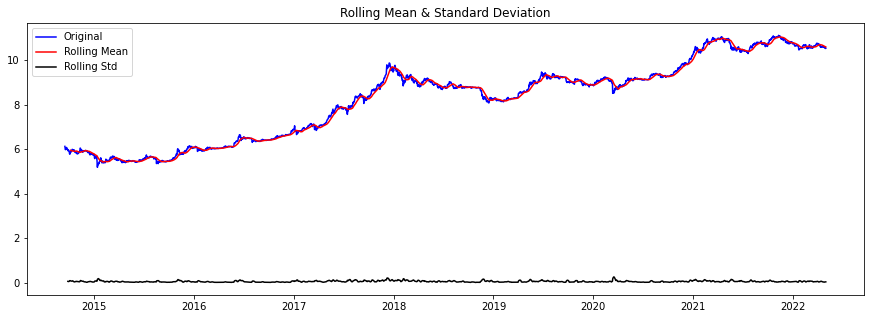

ADF Stastistic: -0.597045
p-value: 0.871648
The graph is non stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [24]:
ts_log = np.log(ts)
plt.plot(ts_log,color="gray")
plt.show()

test_stationarity(ts_log)

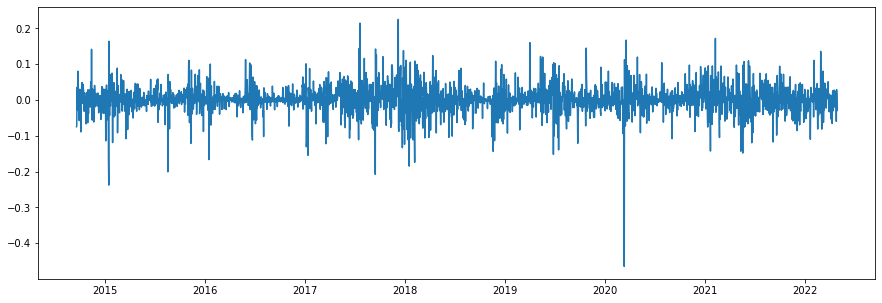

In [25]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.show()

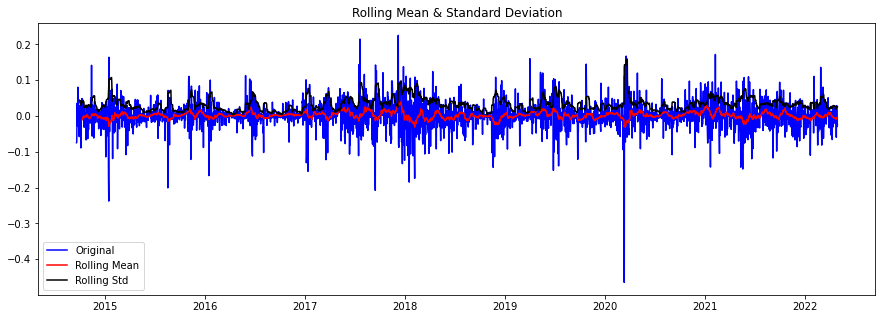

ADF Stastistic: -15.892515
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.433 
	5%: -2.863 
	10%: -2.567 


In [26]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [8]:
def model_fit(model_name, ts_log):
    order = {'ar': (1, 1, 0), 'ma': (0, 1, 1), 'arima': (2, 1, 0)}

    model = ARIMA(ts_log, order=order[model_name])
    return model.fit(disp=-1)

def plot_fitted(results):
    plt.plot(ts_log_diff)
    plt.plot(results.fittedvalues, color='yellow')
    plt.title('RSS: %.7f' % sum(
        (results.fittedvalues - ts_log_diff)**2))
    plt.show()

def pred_value(t):
    model_fited = model_fit('arima', train_arima)
    output = model_fited.forecast()
    train_arima.append(t)

    return float(np.exp(output[0]))

# Auto Regressive model

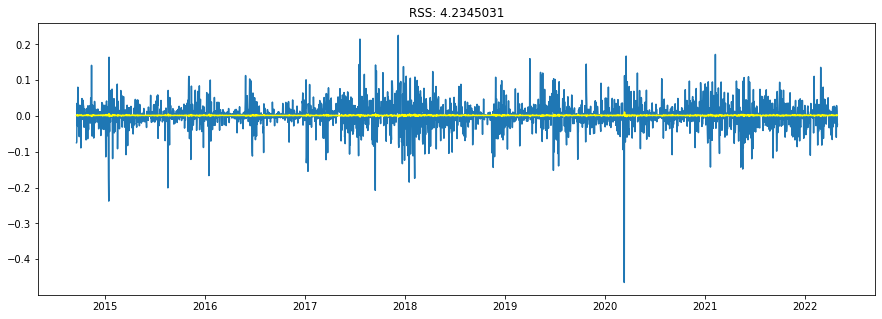

In [27]:
results_AR = model_fit('ar', ts_log)
plot_fitted(results_AR)

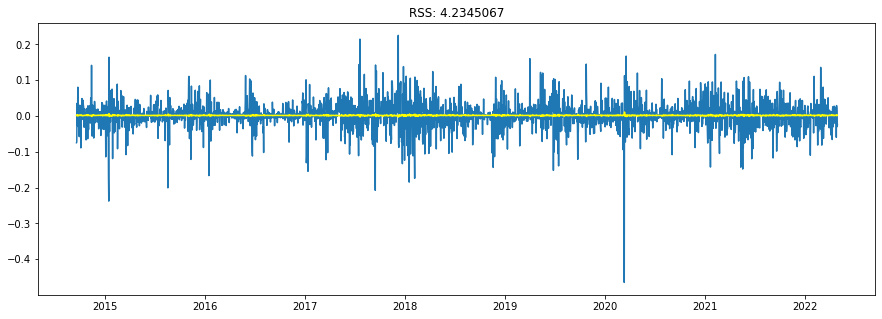

In [28]:
results_ma = model_fit('ma', ts_log)
plot_fitted(results_ma)

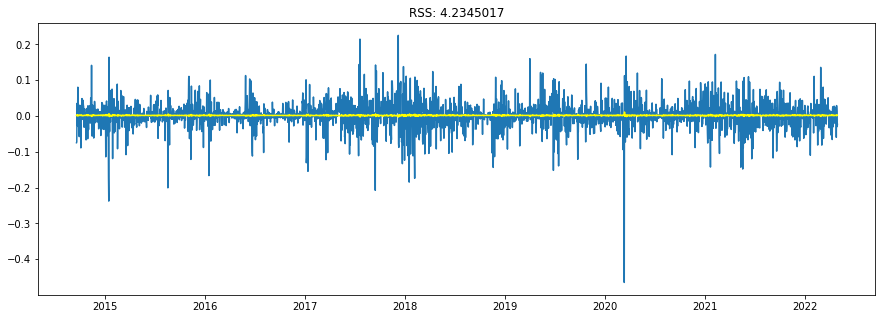

In [29]:
results_arima = model_fit('arima', ts_log)
plot_fitted(results_arima)

          test      original    prediction     error
0    10.965229  57828.050781  57796.997375  0.053700
1    10.944313  56631.078125  57960.650792  2.347779
2    10.954314  57200.292969  56763.280182  0.764004
3    10.884321  53333.539063  57303.319605  7.443310
4    10.958218  57424.007813  53498.222845  6.836487
..         ...           ...           ...       ...
360  10.548428  38117.460938  40505.245960  6.264281
361  10.577480  39241.121094  38225.597055  2.587908
362  10.590964  39773.828125  39279.685742  1.242381
363  10.561262  38609.824219  39829.141361  3.158049
364  10.537810  37714.875000  38696.378203  2.602430

[365 rows x 4 columns]

 Mean Error in Predicting Test Case Articles : 2.790 %


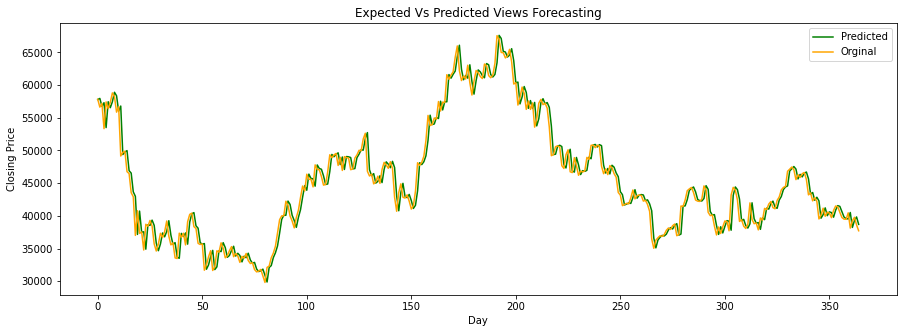

In [30]:
# Divide into train and test
size = len(ts_log) - 365
train_arima = ts_log[:size].to_list()
test_arima = ts_log[size:].to_list()

# Calculate the predictions
results = pd.DataFrame({'test': test_arima})
results['original'] = np.exp(results['test'])
results['prediction'] = results['test'].map(lambda t:pred_value(t))
results['error'] = (abs(results['prediction'] - results['original'])) * 100 / results['original']

# Print the results values
print(results)

# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %.3f' % (round(results['error'].mean(),2)), '%')

# Plot the results
plt.figure(figsize=(15,5))
plt.plot(results.index, results['prediction'], color= 'green')
plt.plot(results.index, results['original'], color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Day')
plt.ylabel('Closing Price')
plt.legend({'Orginal','Predicted'})
plt.show()